<a href="https://colab.research.google.com/github/atharvanaik10/face-recognition/blob/master/Eigenfaces_FINAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Eigenfaces
**'Eigenfaces'** is the name given to a set of eigenvectors that are used in computer vision to build face models. The approach was first used by Matthew Turk and Alex Pentland at the media lab at MIT. Taking inspiration from the paper, I used Principal Component Analysis with Eigendecomposition to create my own model of live FaceID by using a training dataset of people in the class.

###Definitions
***Eigenvectors:*** a nonzero vector that is mapped by a given linear transformation of a vector space onto a vector that is the product of a scalar multiplied by the original vector. 

$ Ax = \lambda x$

***Principal Component Analysis (PCA):*** a statistical procedure that uses an orthogonal transformation to convert a set of observations of possibly correlated variables (entities each of which takes on various numerical values) into a set of values of linearly uncorrelated variables called principal components

***Eigendecomposition:*** diagonalizing the matrix $A$ with eigenvector matrix $P$ and eigenvalue matrix $D$. 

$A = PDP^{-1}$

In [0]:
from google.colab import drive
from google.colab.patches import cv2_imshow
import numpy as np
from scipy import linalg
import cv2
import matplotlib.pyplot as plt
plt.gray()
import PIL.Image
drive.mount("/gdrive")

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


<Figure size 432x288 with 0 Axes>

##Method

As our dataset, we will use square pictures of people in my grade that have been scaled down to a resolution of $256$px. Here is our set of sample faces:

![Dataset Image](https://drive.google.com/uc?id=1JyyeA0TTB1SF-6sS0v4KjtxtjGCaGIRP)

We are using only 16 pictures, however, each picture is highly detailed (256px) which should take up a considerable amount of computing power. We can also see that each image of the same person is different, with different facial expressions, face tilt, or even with/without glasses. This should make it relatively challenging to train and compute, but also make it sufficiently detailed to have faster live recognition.

For this project, we can think of each image as a matrix of pixel values. In the code below, the printed shape shows us that it is a $256 \times 256$ array with $3$ colors (RGB).

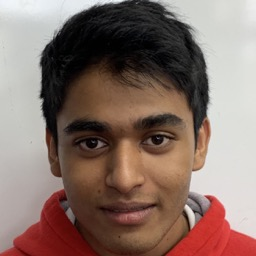


 The shape of this matrix is 3 dimensional:
(256, 256, 3)


In [0]:
img1 = cv2.imread('/gdrive/My Drive/Eigenfaces/Dataset/2.jpg', cv2.IMREAD_UNCHANGED)
cv2_imshow(img1)

print('\n The shape of this matrix is 3 dimensional:')
A1 = np.array(img1)
print (A1.shape)

To make our calculations much simpler, we use grayscale images, with each pixel ranging from $0$ (black) to $255$ (white). By doing so, we can reduce the dimensions of the image from a 3-dimensional RGB to a 1-dimensional grayscale image. In our dataset, we then have a square $(n \times n)$ matrix with integer entries from $0$ to $255$. 



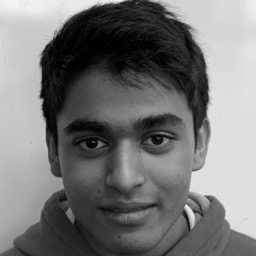


 The shape of the image is 2-dimensional:
(256, 256)

 The matrix A1 for this image is:
[[240 241 242 ... 238 238 238]
 [240 241 242 ... 237 237 237]
 [240 241 242 ... 236 236 236]
 ...
 [121 111 100 ...  96  95  95]
 [ 93  92  91 ...  94  94  93]
 [ 91  90  88 ...  94  95  95]]


In [0]:
img1 = cv2.imread('/gdrive/My Drive/Eigenfaces/Dataset/2.jpg', cv2.IMREAD_GRAYSCALE)
cv2_imshow(img1)

print('\n The shape of the image is 2-dimensional:')
A1 = np.array(img1)
print (A1.shape)
print('\n The matrix A1 for this image is:')
print (A1)




However, each image in a matrix has no use to us, since we want to look at the relationship between two images, and compute how 'similar' two faces are. To solve this issue, we want a *face space,* which we can create by representing one image as a vector by stacking the pixels. This process is called *flattening* the image. By doing so, we end up with image $A$ represented as vector $v$: 

>$ v = (A_{1,1}...A_{1,256}, A_{2,1}...A_{2,256},...,A_{256,1}...A_{256,256})$

This creates a *face space* that is $\mathbb{R}^{n \times n} = \mathbb{R}^{65,536}$. This effectively represents each image in a vector that is $65,536$ dimensions. 

In [0]:
!pip install mtcnn
from os import listdir
from os.path import isdir
from numpy import asarray
from mtcnn.mtcnn import MTCNN


# extract a single face from a given photograph
def extract_face(filename, required_size=(256, 256)):
	# load image from file
	print(filename)
	#image = PIL.Image.open(filename)
	print('passed 1')
	pixels = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
	print('passed 2')
	pixels = cv2.resize(pixels, (800, 800))
	# convert to RGB, if needed
	#image = image.convert('RGB')
	# convert to array
	print('passed 3')
	#pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	print('passed 4')
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	print(results)
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	# image = PIL.Image.fromarray(face)
	# image = image.resize(required_size)
	face_array = cv2.resize(cv2.cvtColor(face, cv2.COLOR_RGB2GRAY), required_size)
	print(face_array.shape)
	return face_array
 
# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		try:
			face = extract_face(path)
			faces.append(face)
		except:
			 print('image failing')
	return faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X = list()
	y = list()
	for subdir in listdir(directory):
		path = directory + subdir + '/'
		if not isdir(path):
			continue
		faces = load_faces(path)
		labels = [subdir for _ in range(len(faces))]
		y.extend(labels)
		print(len(X))
		X.extend(faces)
	return asarray(X),asarray(y)


trainx, trainy = load_dataset('/gdrive/My Drive/Eigenfaces/Dataset2/train/')
testx, testy = load_dataset('/gdrive/My Drive/Eigenfaces/Dataset2/val/')

imgs = np.array([x.flatten() for x in trainx])

tests = np.array([x.flatten() for x in testx])

print(imgs, trainy)

/gdrive/My Drive/Eigenfaces/Dataset2/train/ryan/IMG_6694.JPG
passed 1
passed 2
passed 3










passed 4
[{'box': [256, 205, 252, 342], 'confidence': 0.9999711513519287, 'keypoints': {'left_eye': (315, 342), 'right_eye': (439, 343), 'nose': (371, 403), 'mouth_left': (318, 458), 'mouth_right': (432, 461)}}]
(256, 256)
/gdrive/My Drive/Eigenfaces/Dataset2/train/ryan/IMG_6727.JPG
passed 1
passed 2
passed 3
passed 4
[{'box': [265, 222, 215, 297], 'confidence': 0.999996542930603, 'keypoints': {'left_eye': (315, 344), 'right_eye': (421, 347), 'nose': (365, 400), 'mouth_left': (324, 452), 'mouth_right': (406, 455)}}]
(256, 256)
/gdrive/My Drive/Eigenfaces/Dataset2/train/ryan/IMG_6726.JPG
passed 1
passed 2
passed 3
passed 4
[{'box': [284, 283, 207, 276], 'confidence': 0.9999926090240479, 'keypoints': {'left_eye': (328, 387), 'right_eye': (434, 388), 'nose': (375, 437), 'mouth_left': (329, 483), 'mouth_right': (433, 485)}}]
(256, 256)
/gdrive/My Drive/Eigenfaces/Dataset2/train/ryan/IMG_6690.J

Once we have a vector for each image, we have to calculate the *mean face.* This can be done easily by averaging all pixel values throughout the vectors. For our 16 images, this will look like:
> $v_{avg} = \frac{v_1 + v_2 + ... + v_{16}}{16}$

Doing so results in the following image:

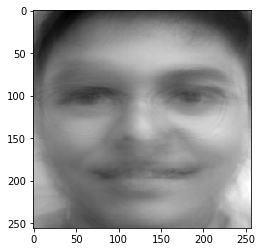

In [0]:
import IPython.display
import PIL.Image
mf = np.mean(imgs, axis = 0)
plt.imshow(np.reshape(mf, (256,256)))


After this, we need to find out how each separate image $A$ differs from our mean. To calculate this deviation, we subtract the mean face from each image. We call these *difference faces* represented by $v_{1'}$:
> $v_{1'} = v_1 - v_{avg}$

In [0]:
imgs2 = np.array([x-mf for x in imgs])
tests2 = np.array([x-mf for x in tests])

We then find the Eigenfaces using our handy Numpy library that makes it easier to conduct matrix multiplication and other essential statistical operations on matrices. The process of finding Eigenfaces is as follows:

1. We find the covariance of our new matrix, which will give us the change of the vectors in relation to each other. This can allow us to graph our correlation and eventually change our basis. $Cov(X,Y) = \frac{\Sigma (X_i - \overline{X})(Y_j - \overline{Y})}{n}$

2. After this, we find the principal components (or eigenvectors) of our new covariance matrix. This gives us the most reduced yet most variant set of features that we can then use to recognise our faces. 

The resultant image (which is actually our eigenvectors) is the 'Eigenface' of an image. In these images, the white areas of each image is the 'uniqueness' of that image, since less brightness values have been subtracted from it. 

(65536, 28)
(28, 28)


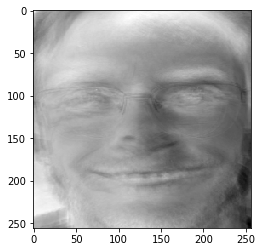

In [0]:
e_faces, sigma, v = linalg.svd(imgs2.transpose(), full_matrices=False)

weights = np.dot(imgs2, e_faces)
print (e_faces.shape)
print(weights.shape)
plt.imshow(np.reshape(e_faces[:,0], (256,256)))

Our next step is to use the KMeans library to cluster our images. We have already found our Principal Components, or Eigenfaces, and now we have to project all our faces into the new basis and cluster the faces. 



Text(0, 0.5, 'Sum of squared distance')

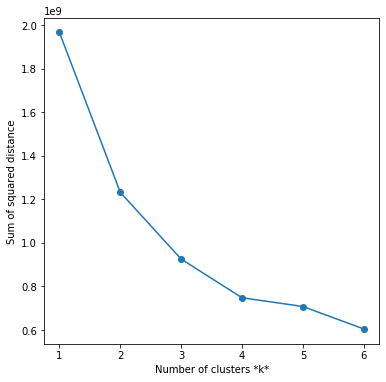

In [0]:
from sklearn.cluster import KMeans
#clusters = KMeans(n_clusters = 4, n_init = 2)
#clusters.fit(weights)

#clusters.cluster_centers_

# Run the Kmeans algorithm and get the index of data points clusters  
kmeansperf = []  
for k in range(1,7):  
  km = KMeans(n_clusters=k, n_init = 4, random_state = 0)  
  km.fit(weights)  
  kmeansperf.append(km.inertia_)  

# Plot perf against k  
plt.figure(figsize=(6, 6))  
plt.plot(range(1,7), kmeansperf, '-o')  
plt.xlabel(r'Number of clusters *k*')  
plt.ylabel('Sum of squared distance')

The graph above shows the number of clusters that will be needed. Our goal is to find an elbow point where the number of clusters (each mapped to a person) is optimal. We know that we have 5 classes, and we can observe that the curve flattens until 5 clusters. For this program, we will hence use 5 clusters, each mapped to a person. 

In [0]:
km = KMeans(n_clusters=5, n_init = 4, random_state = 0)  
km.fit(weights) 
km.labels_

array([2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3,
       3, 3, 3, 3, 1, 3], dtype=int32)

In the code below, we can see an error of PCA, as both Rahil and Ashwin are getting mapper to the same cluster. This is something that cannot be corrected with the data I have, so this will be an anomaly. 

In [0]:
print(list(zip(km.labels_,trainy)))

[(2, 'ryan'), (2, 'ryan'), (2, 'ryan'), (2, 'ryan'), (2, 'ryan'), (2, 'ryan'), (2, 'ryan'), (2, 'ryan'), (4, 'jay'), (4, 'jay'), (4, 'jay'), (4, 'jay'), (0, 'rahil'), (0, 'rahil'), (0, 'rahil'), (0, 'rahil'), (0, 'ashwin'), (0, 'ashwin'), (0, 'ashwin'), (0, 'ashwin'), (0, 'ashwin'), (3, 'dr s'), (3, 'dr s'), (3, 'dr s'), (3, 'dr s'), (3, 'dr s'), (1, 'dr s'), (3, 'dr s')]


In [0]:
testwts = np.dot(tests2, e_faces)
print(testwts.shape)

(19, 28)


In the code below, we map each cluster to a name. With 0 being Rahil, 2 being Ryan and so on. 

In [0]:
lcd = dict({0:'rahil', 2:'ryan', 4:'jay', 3:'dr s'})

The code blow is testing our model. For each array entry, the first input is our prediction and the second input is the actual image. Here we can see that our random testing has yeilded 100% accurate results. 

In [0]:
pred1 = km.predict(testwts)
pred1_class = [lcd[key] for key in pred1]

pred2 = list(zip(pred1_class,testy))
pred2np = asarray(pred2)
print(pred2np)

success = 0
for x in pred2np:
  if x[0] == x[1]:
    success += 1
print('Success rate: ' , success/pred2np.shape[0])

[['jay' 'jay']
 ['jay' 'jay']
 ['jay' 'jay']
 ['jay' 'jay']
 ['rahil' 'rahil']
 ['rahil' 'rahil']
 ['rahil' 'rahil']
 ['ryan' 'ryan']
 ['ryan' 'ryan']
 ['ryan' 'ryan']
 ['ryan' 'ryan']
 ['ryan' 'ryan']
 ['ryan' 'ryan']
 ['dr s' 'dr s']
 ['dr s' 'dr s']
 ['dr s' 'dr s']
 ['dr s' 'dr s']
 ['dr s' 'dr s']
 ['dr s' 'dr s']]
Success rate:  1.0


In [0]:
# extract a single face from a given photograph
def extract_face2(filename, required_size=(256, 256)):
	# load image from file
	#image = PIL.Image.open(filename)
	pixels = cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)
	pixels = cv2.resize(pixels, (800, 800))
	# convert to RGB, if needed
	#image = image.convert('RGB')
	# convert to array
	#pixels = asarray(image)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	# image = PIL.Image.fromarray(face)
	# image = image.resize(required_size)
	face_array = cv2.resize(cv2.cvtColor(face, cv2.COLOR_RGB2GRAY), required_size)
	return face_array
 

The code blow instantiates our camera and allows us to take a picture and save it to our directory. We then retrieve the picture and use the face detection library MTCNN to extract our face from the big picture. We then perform the same transformation into the eigenvector, and use it to map our image to a cluster. Then, our prediction is printed out. 

In [0]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='/gdrive/My Drive/Eigenfaces/Input2/photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [0]:
from IPython.display import Image
try:
  filename = take_photo()

except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

print('Extracting...')
inx1 = extract_face2(filename)
print('Analysing...')
inx2 = inx1.flatten()
inx3 = inx2 - mf
inx4 = np.dot(inx3, e_faces)

pred1 = km.predict(inx4.reshape(1,-1))
print(lcd[pred1[0]])

print('\n\nHello' , lcd[pred1[0]] , '!')

<IPython.core.display.Javascript object>

Extracting...
Analysing...


Hello, dr s !


As we can see, we correctly identify the person in question, and can predict the image fairly accurately.

In conclusion, I think that my code works pretty well and demonstrates the concepts of Linear Algebra (change of basis, eigenvectors) in an engaging way, while using real life applications. Due to this, I'm very proud of what I could acheive in such a short timeframe. 